Aim:
- Repeat Bentzens work but with NPL audit measurement variaiton.
    - This was originally completed using Excel and presented in teh confirmaiton report, but want in python for consistency in plot styles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

mystyle = r'https://gist.githubusercontent.com/mbolt01/3087dffd11e70eccb08fdcf327374a5c/raw/std_fig'
plt.style.use(mystyle)

from scipy import stats

In [2]:
## import data and get only MV beams
filepath = 'NPL_Table_All-ANON-Final-ALL.xlsx'

df = pd.read_excel(filepath)
mv = df[df['Type']=='MV'].sort_values(by=['Date'], ascending=True)
len(mv)
print(df['Date'].min())

1994-06-07 00:00:00


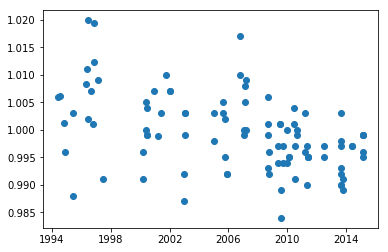

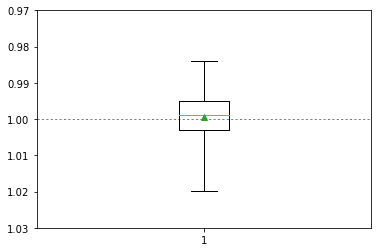

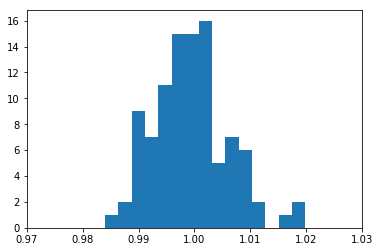

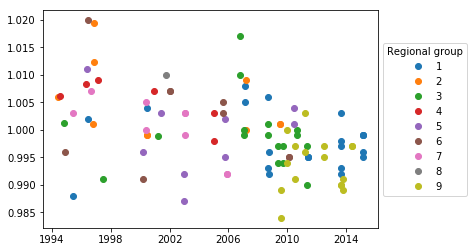

In [3]:
## outputs over time
plt.plot(mv['Date'],mv['OPRatio'],'o')
plt.show()

## boxplot
plt.boxplot(mv['OPRatio'].tolist(),whis='range',showmeans=True)
plt.ylim(1.03,0.97)
plt.axhline(1,color='black',lw=1,ls=':',zorder=0,alpha=0.5)
plt.show()

## histogram
plt.hist(mv['OPRatio'],bins=15)
plt.xlim(0.97,1.03)
plt.show()

## outputs with group highlighting
for group in sorted(mv['Group'].unique()):
    data = mv[mv['Group']==group]
    plt.plot(data['Date'],data['OPRatio'],'o',label=group)
plt.legend(title='Regional group', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## Bentzen repeat for different gammas
- Loop through different gammas to get the plots and allow initial filtering of the data

In [12]:
len(mv[mv['Energy']>6])

47

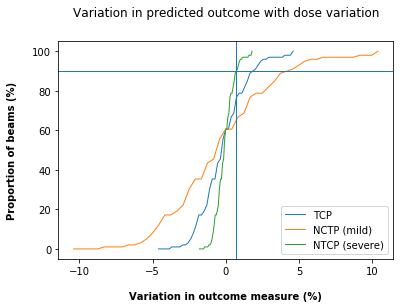

Ttest_indResult(statistic=-0.54678314611621448, pvalue=0.58578338380764561)

In [33]:
## the plots are simply the OP dif * gradient.
## check what did in Excel and create functino to produce plot with supplied gradient(s)

## need to calcualte proportion of beams (every x%). Plot of proportion of beams vs percent opdif (*grad)
min_pt = -2.5
max_pt = 2.5
num_per_perc = 10
range_of_interest = np.linspace(-2,2,(max_pt-min_pt)*num_per_perc+1) ## get range of percent values

grads = {2.3:'TCP',
         5.2:'NCTP (mild)',
         0.9: 'NTCP (severe)'
         }

data1 = mv[mv['Energy']<=6] ## for filtering the data by energy etc.
data2 = mv[mv['Energy']>6]
data3 = mv

ls=['-','--']
markers = ['o','^','x']
colors = ['C0','C1','C2']

j=0

#for data in [data1,data2]:
for data in [data3]:
    k=0

    for grad in [2.3,5.2,0.9]:

        ops = []
        counts = []

        for i in range_of_interest:
            count = len(data[data['OPRatio']<=(i/100)+1]) ## convert percent to ratio for comparison
            ops.append(i*grad)
            counts.append(100*count/len(data))
        if j==0: ## only put in 1 set of labels
            plt.plot(ops,counts,marker='',color=colors[k],lw=1,ms=2,label=grads[grad],ls=ls[j])
        else:
            plt.plot(ops,counts,marker='',color=colors[k],lw=1,ms=2,label=None,ls=ls[j])
        k=k+1
    j=j+1


plt.xlabel('Variation in outcome measure (%)')
plt.ylabel('Proportion of beams (%)')
#plt.title('Variation in predicted outcome with dose variation \n ($\leq$6MV = solid, >6MV = dashed)')
plt.title('Variation in predicted outcome with dose variation')
plt.legend()
#plt.savefig('plots/bentzen_npl_repeat.png',dpi=300,bbox_inches='tight')

plt.axhline(90,lw=1)
plt.axvline(0.7,lw=1)

plt.show()

## check if normal distribution of each set of data is true. Then compare with t-test.
d1 = data1['OPRatio'].tolist()
d2 = data2['OPRatio'].tolist()



stats.ttest_ind(d1,d2)

##  Bentzen repeat for different sets of results
- (e.g. compare difernet energies, or different datasets)
- Loop through different specified sets of data (or supplied lists of output values)

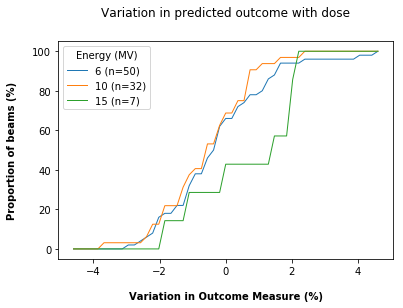

F_onewayResult(statistic=2.2857041494982342, pvalue=0.02820971966162136)

In [5]:
## get the different sets of values as a list
vals1 = mv[mv['Energy']<=6]['OPRatio'].tolist()
vals2 = mv[mv['Energy']>6]['OPRatio'].tolist()

combined_list = [vals1,vals2] ## for ANOVA purposes...

## combine value lists into a dict to specifiy labels (and poss other info)
all_vals = {'<=6MV':vals1,
           '>6MV':vals2,
           }

## try to automatically create a dict usign a loop through the dataframe of data
## try splitting into each 'group'
all_vals = {}
combined_list = []
for group in sorted(mv['Energy'].unique()):
    key = group
    item = mv[mv['Energy']==group]['OPRatio'].tolist()
    all_vals[key] = item
#    print(group,len(item))
    combined_list.append(item) ## for ANOVA purposes...

legend_title = 'Energy (MV)'
    
min_pt = -2.5
max_pt = 2.5
num_per_perc = 10
range_of_interest = np.linspace(-2,2,(max_pt-min_pt)*num_per_perc+1) ## get range of percent values

grad = 2.3 ## single grad for multiple datasets

for val in sorted(all_vals): ## need to supply dict of labelled lists whcih could be generated in a number of ways
    data = all_vals[val]
    label = val

    ops = []
    counts = []

    for i in range_of_interest:
        count = len([j for j in data if 100*(j-1) <= i]) ## convert ratio to percent for comparison
        ops.append(i*grad)
        counts.append(100*count/len(data))

    if len(data)>=5: ## only plot if over certain number of results
        plt.plot(ops,counts,marker='',lw=1,ms=2,label=str(label) + ' (n=' + str(len(data)) + ')')

plt.xlabel('Variation in Outcome Measure (%)')
plt.ylabel('Proportion of beams (%)')
plt.title('Variation in predicted outcome with dose')
plt.legend(title=legend_title)
plt.show()

stats.ttest_ind(vals1,vals2,equal_var=True) ## compares 2 samples
#stats.ttest_1samp(vals2,1) ## compares data to an assumed mean
stats.f_oneway(*combined_list) ## compares means and assumes normality
#stats.kruskal(*combined_list) ## compares medians and does not assume normality

## Useful ANOVA ref:
http://hamelg.blogspot.co.uk/2015/11/python-for-data-analysis-part-16_23.html

- details use of stats.f_oneway to determine if any differcne
- then compare each pair of data togther to determine which is odd one out = 'post-hoc test'

In [6]:
from itertools import combinations ##  for producing the required pairs of data to test
for i in combinations(all_vals.keys(), 2): ##loop through all combinations of datasets based on the dict key
    stat_result = stats.ttest_ind(all_vals[i[0]],all_vals[i[1]]).pvalue
    
    bonferroni = 0.05/len(all_vals)
    
    if stat_result <bonferroni: ##only display non matching results
        print('FALSE', i[0],i[1],stat_result)
    else:
        print('TRUE', i[0],i[1],stat_result)
        
## more 'powerful' way to adjust p values is the Holm-bonferroni correction.
## this sorts results into order of p-value and compares each agaisnt a differtn value which changes as the number of checked values advances
## the idea is that you stop once one is found significant (would you then miss some other signif values?)

TRUE 16 18 nan
TRUE 16 4 nan
TRUE 16 5 nan
TRUE 16 6 nan
TRUE 16 8 nan
TRUE 16 25 nan
TRUE 16 10 nan
TRUE 16 15 nan
TRUE 18 4 nan
TRUE 18 5 nan
TRUE 18 6 0.449387800273
TRUE 18 8 0.698521501457
TRUE 18 25 nan
TRUE 18 10 0.227116660709
TRUE 18 15 0.982995298947
TRUE 4 5 nan
TRUE 4 6 nan
TRUE 4 8 nan
TRUE 4 25 nan
TRUE 4 10 nan
TRUE 4 15 nan
TRUE 5 6 nan
TRUE 5 8 nan
TRUE 5 25 nan
TRUE 5 10 nan
TRUE 5 15 nan
TRUE 6 8 0.0639977566651
TRUE 6 25 nan
TRUE 6 10 0.361069809424
TRUE 6 15 0.171304501011
TRUE 8 25 nan
TRUE 8 10 0.0175908529524
TRUE 8 15 0.562159727118
TRUE 25 10 nan
TRUE 25 15 nan
TRUE 10 15 0.0443832002892


C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


## comparison of first and last n results

********5********


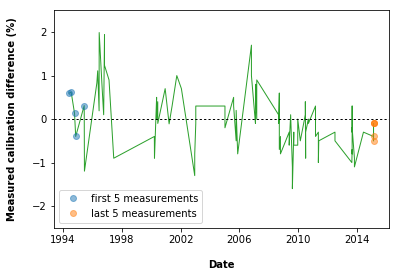

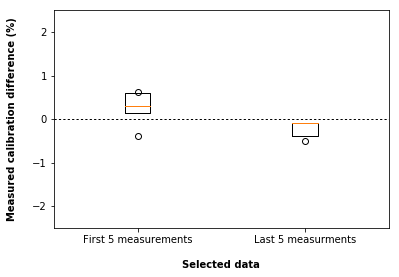

********10********


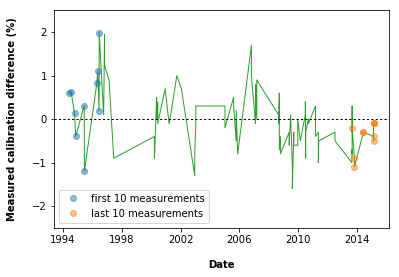

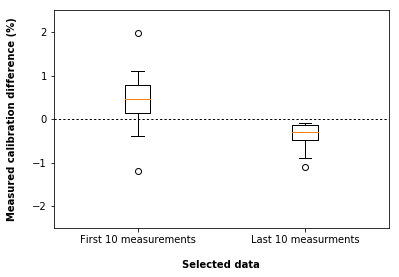

********15********


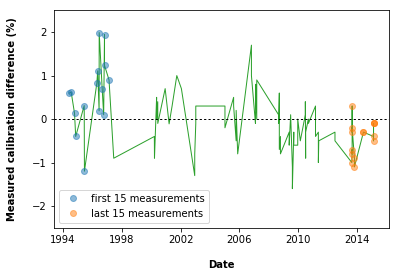

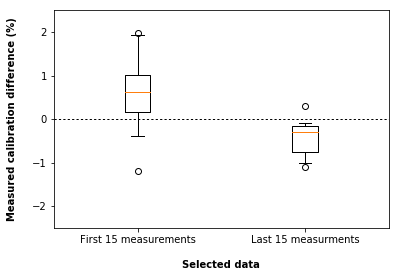

********20********


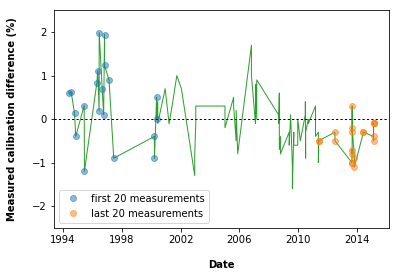

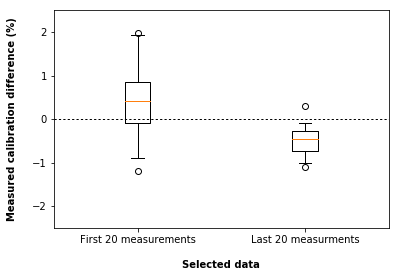

********25********


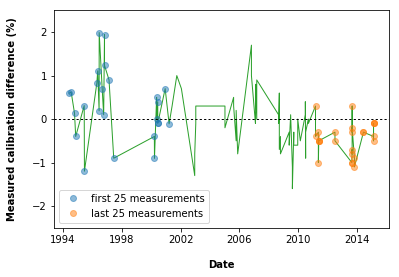

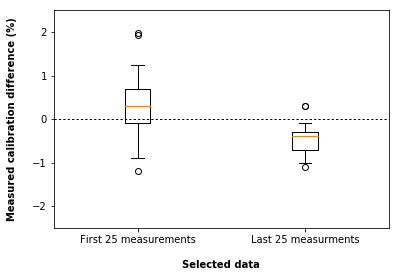

********30********


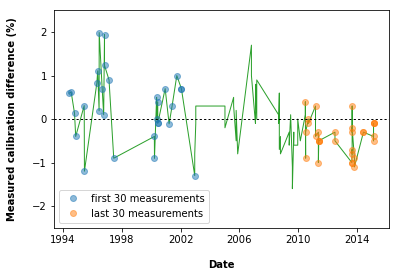

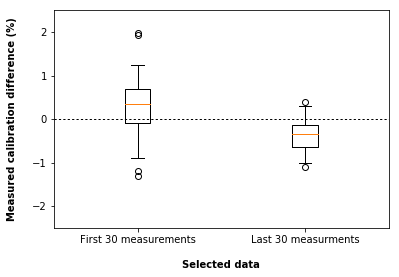

********40********


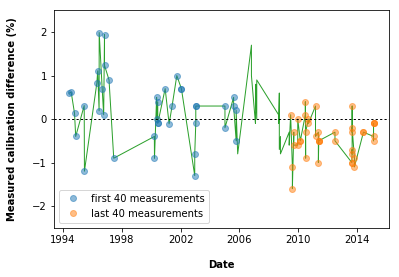

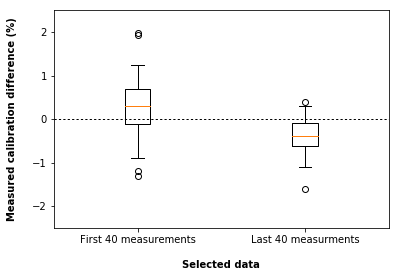

In [7]:
## get all results (df is ordered by date already)
all_ops = [(i-1)*100 for i in mv['OPRatio'].tolist()] ## convert ratio to percentage
all_dates = mv['Date'].tolist()

## set n
n = int(len(all_ops)/2)
n = 15

for n in [5,10,15,20,25,30,40]:
    print('********' + str(n) + '********')

    first_n = all_ops[:n]
    first_n_dates = all_dates[:n]

    last_n = all_ops[-n:]
    last_n_dates = all_dates[-n:]

    ## plot selected values over time
    plt.plot(first_n_dates,first_n,'o',label='first '+str(n)+str(' measurements'),alpha=0.5)
    plt.plot(last_n_dates,last_n,'o',label='last '+str(n)+str(' measurements'),alpha=0.5)
    plt.plot(all_dates,all_ops,lw=1,zorder=0)
    plt.axhline(0, ls=':', c='black', lw=1)
    plt.ylim(-2.5,2.5)
    plt.ylabel('Measured calibration difference (%)')
    plt.xlabel('Date')
    plt.legend()
    plt.show()

    ## boxplots for each of the 2 sets

    plt.boxplot([first_n,last_n],labels=['First ' + str(n) + ' measurements','Last ' + str(n) + ' measurments'],whis=[5,95])
    plt.axhline(0, ls=':', c='black', lw=1)
    plt.ylim(-2.5,2.5)
    plt.ylabel('Measured calibration difference (%)')
    plt.xlabel('Selected data')
    plt.show()

In [8]:
mv.head()

,Centre_ID,Group,CentreType,Date,Type,Energy,CoP,BeamQualRatio,BeamQualError,OPRatio,OPError,IntercompRatio,IntercompError,Comments
0,14,2,NHS,1994-06-07,MV,8,NaN,0.985788,0.2,1.005968,0.2,0.999252,0.4,NaN
1,40,4,NHS,1994-07-27,MV,6,NaN,1.002496,0.2,1.006191,0.2,NaN,NaN,NaN
10,26,3,NHS,1994-10-18,MV,6,NaN,0.993704,0.2,1.001325,0.2,1.009011,0.4,NaN
11,7,6,NHS,1994-11-16,MV,8,NaN,1.000560,0.2,0.996000,0.2,0.994340,0.4,NaN
12,22,7,NHS,1995-06-15,MV,6,NaN,1.010253,0.2,1.003109,0.2,1.003175,0.4,NaN
